# Libraries

In [7]:
## Importing all relevant libraries

import random
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

import torch

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# The Data

In [8]:
df = pd.read_excel("/project/class/bii_sdad_dspg/uva_2021/binn/Data_600_Labeled_Final.xlsx", index_col=0) ## Reading in data
df_save = df.reset_index(inplace=False, drop = True)
#df = df[['full_text', 'YN_INNOVATION']].reset_index(inplace=False, drop = True)
df = df.reset_index(inplace=False, drop = True)

## Balancing target class 

df_yes = df[df.YN_INNOVATION == 'yes']
df_no = df[df.YN_INNOVATION == 'no']

if len(df_yes) == len(df_no):
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_yes) > len(df_no):
    df_yes = df_yes.sample(n=len(df_no), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_no) > len(df_yes):
    df_no = df_no.sample(n=len(df_yes), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
df = df.sample(n=len(df), random_state = 65432).reset_index(inplace=False, drop = True)

    
print("Value counts for target variable:\n",df.YN_INNOVATION.value_counts())

## Encoding target variable

le = preprocessing.LabelEncoder()
df.YN_INNOVATION = le.fit_transform(df.YN_INNOVATION)
print("\n\n\nThe target variable classes are:", le.classes_)

Value counts for target variable:
 yes    222
no     222
Name: YN_INNOVATION, dtype: int64



The target variable classes are: ['no' 'yes']


# CLASSIFICATION

In [9]:
labels = df.YN_INNOVATION ## Target variable

## BERT BASE UNCASED RBF KERNEL BASED SVM

In [10]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel, 
                                                    AutoTokenizer, 
                                                    [ 'distilbert-base-uncased', 'google/bigbird-roberta-base'])

In [11]:
features_dict = {} ## Empty dict to store features

for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(weights)
    model = model_class.from_pretrained(weights)
    ## Tokenization
    tokenized = df['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    print("The shape of the attention mask is:", attention_mask.shape, "for", weights)

    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (444, 512) for distilbert-base-uncased


Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.b

The shape of the attention mask is: (444, 512) for google/bigbird-roberta-base


In [12]:
features_dict

{'distilbert-base-uncased': array([[-0.2456288 ,  0.00811539,  0.03792296, ..., -0.2318283 ,
          0.5524184 ,  0.24053887],
        [-0.40273327,  0.07335662, -0.1849104 , ..., -0.14998093,
          0.33042708,  0.39937165],
        [-0.1409555 , -0.18729596,  0.01294378, ..., -0.25833228,
          0.26155674,  0.21453358],
        ...,
        [-0.31572565, -0.35711145,  0.12567568, ...,  0.05902517,
          0.32910675,  0.29650986],
        [-0.04902904, -0.01457188, -0.21376294, ...,  0.07341403,
          0.58608055,  0.29470202],
        [-0.25263914, -0.0041946 , -0.03589789, ..., -0.12545717,
          0.39904007,  0.3643861 ]], dtype=float32),
 'google/bigbird-roberta-base': array([[ 0.26742566,  0.35120788,  0.04151607, ...,  0.00136495,
         -0.2628075 ,  0.36169332],
        [ 0.13757473,  0.24778059,  0.03712941, ...,  0.08633371,
         -0.04851794,  0.22073507],
        [ 0.04283896,  0.43629947, -0.00428134, ..., -0.01148461,
         -0.28737321,  0.31200

In [57]:
## Splitting th data into train and test sets of features and target
train_features_dict = {}
test_features_dict = {}
train_labels_dict = {}
test_labels_dict = {}

for weights, features in features_dict.items():
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 65432)
    train_features_dict.update({weights:train_features})
    test_features_dict.update({weights:test_features})
    train_labels_dict.update({weights:train_labels})
    test_labels_dict.update({weights:test_labels})

In [58]:
pretrained_weights

['distilbert-base-uncased', 'google/bigbird-roberta-base']

In [59]:
test_labels_predict_dict = {}
test_labels_predict_proba_dict = {}

model = 'lr' ## while inside of loop to loop on different ML methods:

for key in pretrained_weights:
    if key == 'distilbert-base-uncased':
        while model == "lr": ## Support Vector Machine DISTILBERT
            clf = make_pipeline(StandardScaler(), LogisticRegression(solver="sag", random_state = 65432))
            clf.fit(train_features_dict[key],train_labels_dict[key])
            predicted_y = clf.predict(test_features_dict[key])
            pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
            test_labels_predict_dict.update({key+"_"+"lr":predicted_y})
            test_labels_predict_proba_dict.update({key+"_"+"lr":pred_prob})
            model = "svm"
        while model == "svm": ## Logistic Regression DISTILBERT
            clf = make_pipeline(StandardScaler(), svm.SVC(kernel = "rbf", probability=True, random_state = 65432))
            clf.fit(train_features_dict[key],train_labels_dict[key])
            predicted_y = clf.predict(test_features_dict[key])
            pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
            test_labels_predict_dict.update({key+"_"+"rbf-kernel":predicted_y})
            test_labels_predict_proba_dict.update({key+"_"+"rbf-kernel":pred_prob})
            model = None
            
    elif key == 'google/bigbird-roberta-base':
        clf = make_pipeline(StandardScaler(), LogisticRegression(solver="sag", random_state = 65432))
        clf.fit(train_features_dict[key],train_labels_dict[key])
        predicted_y = clf.predict(test_features_dict[key])
        pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
        test_labels_predict_dict.update({key+"_"+"lr":predicted_y})
        test_labels_predict_proba_dict.update({key+"_"+"lr":pred_prob})


/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [60]:
test_labels_predict_dict

{'distilbert-base-uncased_lr': array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1]),
 'distilbert-base-uncased_rbf-kernel': array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1]),
 'google/bigbird-roberta-base_lr': array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,

In [61]:
pretrained_weights

['distilbert-base-uncased', 'google/bigbird-roberta-base']

In [62]:
cv_scores_dict

{}

In [63]:
features_dict

{'distilbert-base-uncased': array([[-0.2456288 ,  0.00811539,  0.03792296, ..., -0.2318283 ,
          0.5524184 ,  0.24053887],
        [-0.40273327,  0.07335662, -0.1849104 , ..., -0.14998093,
          0.33042708,  0.39937165],
        [-0.1409555 , -0.18729596,  0.01294378, ..., -0.25833228,
          0.26155674,  0.21453358],
        ...,
        [-0.31572565, -0.35711145,  0.12567568, ...,  0.05902517,
          0.32910675,  0.29650986],
        [-0.04902904, -0.01457188, -0.21376294, ...,  0.07341403,
          0.58608055,  0.29470202],
        [-0.25263914, -0.0041946 , -0.03589789, ..., -0.12545717,
          0.39904007,  0.3643861 ]], dtype=float32),
 'google/bigbird-roberta-base': array([[ 0.26742566,  0.35120788,  0.04151607, ...,  0.00136495,
         -0.2628075 ,  0.36169332],
        [ 0.13757473,  0.24778059,  0.03712941, ...,  0.08633371,
         -0.04851794,  0.22073507],
        [ 0.04283896,  0.43629947, -0.00428134, ..., -0.01148461,
         -0.28737321,  0.31200

In [73]:
cv_scores_dict

{'distilbert-base-uncased_lr': 0.8246892655367232,
 'distilbert-base-uncased_rbf-kernel': 0.8596610169491525,
 'google/bigbird-roberta-base_lr': 0.8162994350282485}

In [64]:
## Cross validating with df_save 600 observations
#model = "lr"
cv_scores_dict = {}
features_dict = {} ## Empty dict to store features
labels = le.fit_transform(df_save[df_save.YN_INNOVATION != "TOSS"].YN_INNOVATION) ## Target variable

for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    
    tokenizer = tokenizer_class.from_pretrained(weights)
    
    model = model_class.from_pretrained(weights)
    
    ## Tokenization
    tokenized = df_save[df_save.YN_INNOVATION != "TOSS"]['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    print("The shape of the attention mask is:", attention_mask.shape, "for", weights)
    
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})
        
        
        
for key in pretrained_weights:
    if key == 'distilbert-base-uncased':
        ## LR
        clf = make_pipeline(StandardScaler(), LogisticRegression(solver="sag", random_state = 65432))
        clf.fit(train_features_dict[key],train_labels_dict[key])
        scores = cross_val_score(clf, features_dict[key], labels, cv=10)
        scores = np.mean(scores)
        cv_scores_dict.update({key+"_"+"lr":scores})
        #model = "svm"
            

        clf = make_pipeline(StandardScaler(), svm.SVC(kernel = "rbf", probability=True, random_state = 65432))
        clf.fit(train_features_dict[key],train_labels_dict[key])
        scores = cross_val_score(clf, features_dict[key], labels, cv=10)
        scores = np.mean(scores)
        cv_scores_dict.update({key+"_"+"rbf-kernel":scores})
        #model = None
            
    elif key == 'google/bigbird-roberta-base':
        clf = make_pipeline(StandardScaler(), LogisticRegression(solver="sag", random_state = 65432))
        clf.fit(train_features_dict[key],train_labels_dict[key])
        scores = cross_val_score(clf, features_dict[key], labels, cv=10)
        scores = np.mean(scores)
        cv_scores_dict.update({key+"_"+"lr":scores})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The shape of the attention mask is: (599, 512) for distilbert-base-uncased


Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.b

The shape of the attention mask is: (599, 512) for google/bigbird-roberta-base


/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/far3jh/.conda/envs/DiggyConda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/far3jh/.conda/envs/DiggyConda/lib/python3.

In [65]:
for key in pretrained_weights:
    print(key)

distilbert-base-uncased
google/bigbird-roberta-base


In [66]:
cv_scores_dict

{'distilbert-base-uncased_lr': 0.8246892655367232,
 'distilbert-base-uncased_rbf-kernel': 0.8596610169491525,
 'google/bigbird-roberta-base_lr': 0.8162994350282485}

In [67]:
test_labels_predict_dict.keys()

dict_keys(['distilbert-base-uncased_lr', 'distilbert-base-uncased_rbf-kernel', 'google/bigbird-roberta-base_lr'])


========= distilbert-base-uncased_lr model ==========

Accuracy of the of the distilbert-base-uncased_lr model is 87.39%.
Precision rate of the distilbert-base-uncased_lr model is 83.08%.
Recall rate of the distilbert-base-uncased_lr model is 94.74%.
F-1 score of the distilbert-base-uncased_lr model is 88.52%.
The Cross Validation score of the distilbert-base-uncased_lr model is 82.47%

The confusion matrix for the distilbert-base-uncased_lr model is:


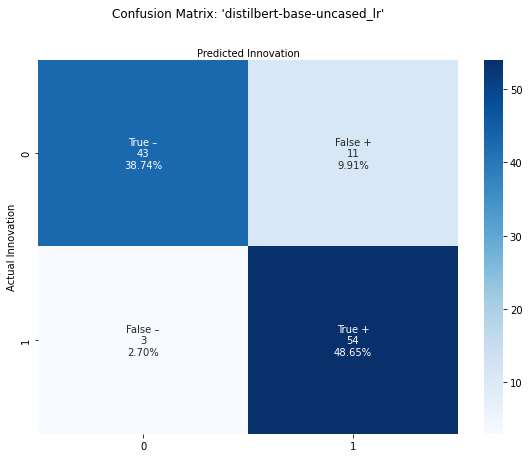

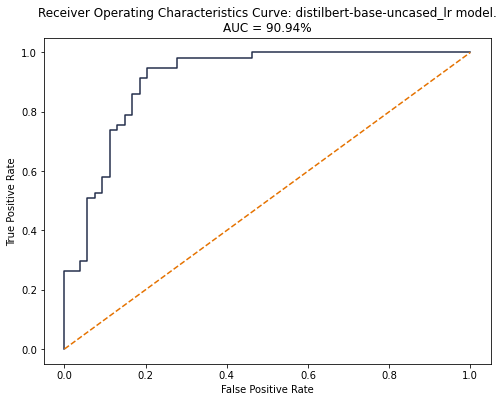


========= distilbert-base-uncased_rbf-kernel model ==========

Accuracy of the of the distilbert-base-uncased_rbf-kernel model is 90.09%.
Precision rate of the distilbert-base-uncased_rbf-kernel model is 83.82%.
Recall rate of the distilbert-base-uncased_rbf-kernel model is 100.0%.
F-1 score of the distilbert-base-uncased_rbf-kernel model is 91.2%.
The Cross Validation score of the distilbert-base-uncased_rbf-kernel model is 85.97%

The confusion matrix for the distilbert-base-uncased_rbf-kernel model is:


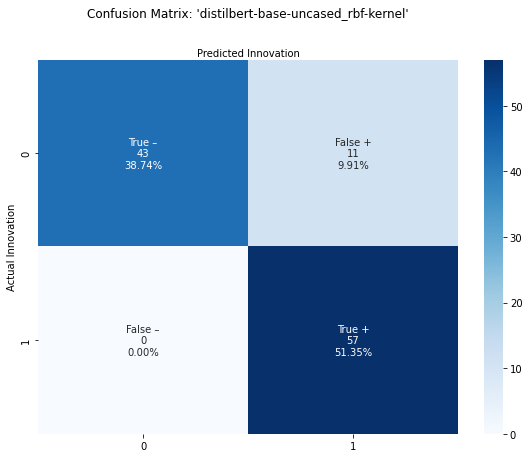

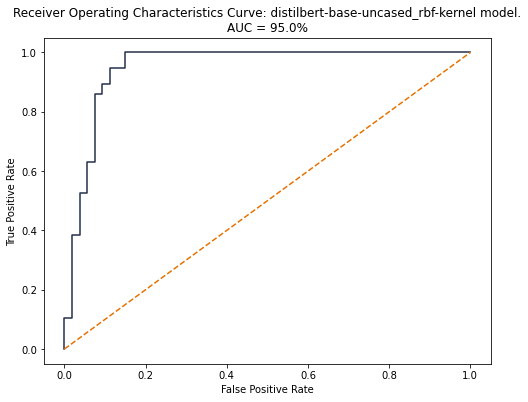


========= google/bigbird-roberta-base_lr model ==========

Accuracy of the of the google/bigbird-roberta-base_lr model is 85.59%.
Precision rate of the google/bigbird-roberta-base_lr model is 82.54%.
Recall rate of the google/bigbird-roberta-base_lr model is 91.23%.
F-1 score of the google/bigbird-roberta-base_lr model is 86.67%.
The Cross Validation score of the google/bigbird-roberta-base_lr model is 81.63%

The confusion matrix for the google/bigbird-roberta-base_lr model is:


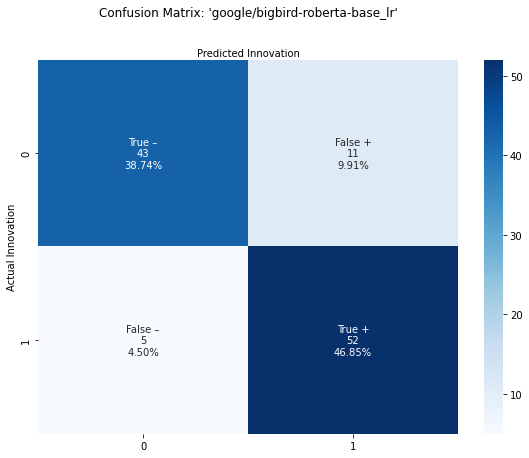

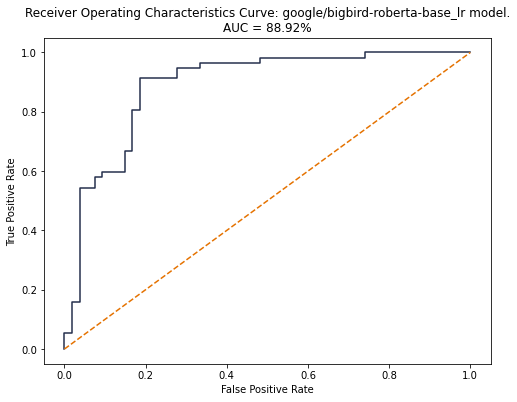

In [74]:
labels = df.YN_INNOVATION ## Target variable

for key in test_labels_predict_dict.keys():
    print("\n=========",key, "model ==========\n")
    key0 = str.split(key, "_")[0]
    
    # Metrics
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    cv_score = cv_scores_dict[key]
    
    print("Accuracy of the of the", key ,"model is {}%.".format(round((accuracy*100),2)))
    print("Precision rate of the", key, "model is {}%.".format(round((precision*100),2)))
    print("Recall rate of the", key, "model is {}%.".format(round((recall*100),2)))
    print("F-1 score of the", key, "model is {}%.".format(round((f1_score*100),2)))
    print("The Cross Validation score of the", key, "model is {}%".format(round(cv_score*100, 2)))
    
    # Confusion Matrix
    print("\nThe confusion matrix for the", key,"model is:")
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    group_names = ["True –","False +","False –","True +"]
    group_counts = ["{0:0.0f}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()/np.sum(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]), annot=labels, fmt='', cmap='Blues')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix: %r'%key, y=1.1)
    plt.ylabel('Actual Innovation')
    plt.xlabel('Predicted Innovation')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    plt.savefig(('/project/class/bii_sdad_dspg/uva_2021/binn/images/classification/'+key.replace("/", "")+'_classifier_cf_matrix.png'), dpi = 600, bbox_inches='tight')
    plt.show()
    
    # ROC Graph
    fpr, tpr, thresholds = roc_curve(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])

    plt.plot(fpr, tpr, color = '#232D4B')
    plt.plot([0, 1], [0, 1], linestyle='--', color="#E57200")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics Curve: "+key+" model.\nAUC = "+str(round(auc*100, 2))+"%")
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    plt.savefig(('/project/class/bii_sdad_dspg/uva_2021/binn/images/classification/'+key.replace("/", "")+'_classifier_roc_curve.png'), dpi = 600, bbox_inches='tight')
    plt.show()

In [13]:
df_new_yn = pd.read_csv("/home/asr8r/git/dspg21binn/data/100k_articles_index_innovation_classification_prediction_diggy.csv", index_col=0)

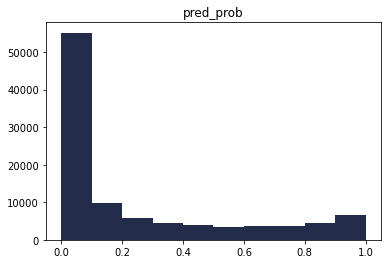

In [21]:
ax = df_new_yn.hist("pred_prob", grid = False, color = ['#232D4B'])


In [17]:
df_new_yn

,an,pred_y,pred_prob
0,JOENG00020170313ed3d00015,0,0.353482
1,COMWKN0020170223ed2n0002f,1,0.988424
2,TELAM00020171020edak000jh,1,0.974480
3,PZON000020170112ed1c0001u,1,0.913724
4,COMWKN0020170817ed8h0009w,1,0.778763
...,...,...,...
96,TAIP000020170405ed4500005,0,0.034230
97,KRTCY00020170507ed5700003,0,0.014792
98,BLDW000020170727ed7r0002x,0,0.000948
99,UWIR000020170805ed840002v,1,0.645509
